In [1]:
import scipy.integrate
import numpy
import matplotlib.pyplot as plt
# beta가 감염률
# gamma가 회복률

In [2]:
# ODEs
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    
    dS_dt = -beta*S*I
    dI_dt = beta*S*I - gamma*I
    dR_dt = gamma*I
    
    return([dS_dt,dI_dt,dR_dt])

In [47]:
# Initial conditions
# 인구수 51780579
S0 = 95185
I0 = 3688
R0 = 48
#beta = 0.1
gamma = 0.1

# Time vector
t = numpy.linspace(0,60,10000)
t


array([0.00000000e+00, 6.00060006e-03, 1.20012001e-02, ...,
       5.99879988e+01, 5.99939994e+01, 6.00000000e+01])

In [92]:
test = S0 + I0 + R0
S0 = S0/test
I0 = I0/test
R0 = R0/test

In [93]:
test

999.9278493969717

In [94]:
Ro = 3.11 # 1인당 전파율
To = 336 # 14*24 회복기간 2주  *  24시간
beta = (Ro/To) + (Ro/(To*S0))*10
beta = 0.35
print(beta)

# Result
solution = scipy.integrate.odeint(SIR_model, [S0,I0,R0], t, args=(beta, gamma))
solution = numpy.array(solution)

0.35


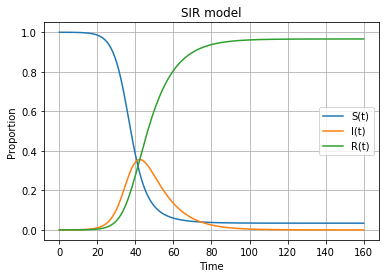

In [95]:
# plot result
plt.figure(figsize=[6,4])
plt.plot(t, solution[:, 0], label="S(t)")
plt.plot(t, solution[:, 1], label="I(t)")
plt.plot(t, solution[:, 2], label="R(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion")
plt.title("SIR model")
plt.show()

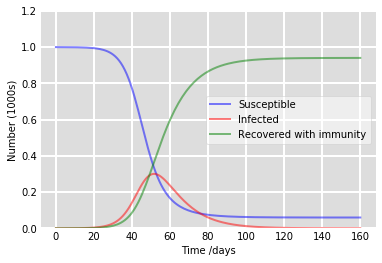

In [97]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
# 인구수 51780579
N = (51780579-(48+3688))/51780579*1000

# 초기 감염 및 치유or사망한 사람 수 I0 , R0.
I0, R0 = 3688/51780579*1000, 48/51780579*1000
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.3, 1./10
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [2]:
"""
Copyright (c) 2020 IIH

Permission is hereby granted, free of charge, to any person
obtaining a copy of this software and associated documentation
files (the "Software"), to deal in the Software without
restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following
conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
OTHER DEALINGS IN THE SOFTWARE.
"""


from scipy.optimize import dual_annealing, shgo
from scipy.integrate import odeint
from scipy.signal import savgol_filter
import numpy as np
import re

parameter = None


def load(csv, line=np.hstack((range(1, 32), 33, 34))):
    csv = open(csv, 'r').readlines()
    return list(map(lambda l: re.split('[,\n]+', csv[l])[:-1], line))


def read(cov_data, population, start, stop, smooth=True):
    smoothing = lambda x: savgol_filter(x, 3, 2) if smooth else x
    return list(map(lambda x: {'state': cov_data[x, 0, 0],
                               'y': smoothing(cov_data[x, :, 4:].astype(np.float)),
                               'p': int(population[x])}, range(start, stop)))


def model(args, init_y, t):

    def DIFF_SEIR(y, _, beta, sigma, gamma, epsilon):
        dSdt = - beta * y[0] * y[2] / y.sum()
        dEdt = (beta * y[0] * y[2] / y.sum()) - (sigma * y[1])
        dIdt = (sigma * y[1]) - ((gamma + epsilon) * y[2])
        dRdt = gamma * y[2]
        dDdt = epsilon * y[2]
        return dSdt, dEdt, dIdt, dRdt, dDdt

    return odeint(DIFF_SEIR, init_y, np.arange(t), tuple(args)).T


def model_loss(args, init_y, y):
    est_y = model(args, init_y, y.shape[1])
    err = ((y - est_y[2:]) ** 2).sum()
    return 2 * ((1 + err) ** 0.5 - 1)


def model_fit(init_y, y):
    return dual_annealing(model_loss, ((0, 50), (0, 1), (0, 1), (0, 1)), args=(init_y, y), maxiter=30, seed=0)


def e_loss(e, data):
    global parameter
    y, population = data['y'], data['p']
    init_y = np.hstack((population - e - y[:, 0].sum(), e, y[:, 0]))
    parameter = model_fit(init_y, y)
    est_y = model(parameter['x'], init_y, y.shape[1])[2:]
    return ((est_y - y) ** 2).sum()


def fit(data):
    return shgo(e_loss, ((1, data['p'] / 100000),), args=(data, ))

# 인구수 51780579
def main():
    data = np.asarray([load('time_series_19-covid-Confirmed.csv'),
                       load('time_series_19-covid-Recovered.csv'),
                       load('time_series_19-covid-Deaths.csv')], dtype='<U14').swapaxes(0, 1)
    population = 51780579#open('population.csv').read().split('\n')

    data = {'Korea': read(data, population, 32, 33)}

    data['Korea'][0]['y'] = np.hstack((data['Korea'][0]['y'], np.array([[3526], [30], [17]])))
    exposed = fit(data['Korea'][0]).x

if __name__ == "__main__":
    main()

TypeError: 'int' object is not subscriptable

In [143]:
data = np.asarray([load('time_series_19-covid-Confirmed.csv'),
                   load('time_series_19-covid-Recovered.csv'),
                   load('time_series_19-covid-Deaths.csv')], dtype='<U14').swapaxes(0, 1)
data[1]

array([['Beijing', 'Mainland China', '40.1824', '116.4142', '14', '22',
        '36', '41', '68', '80', '91', '111', '114', '139', '168', '191',
        '212', '228', '253', '274', '297', '315', '326', '337', '342',
        '352', '366', '372', '375', '380', '381', '387', '393', '395',
        '396', '399', '399', '399', '400', '400', '410', '410', '411'],
       ['Beijing', 'Mainland China', '40.1824', '116.4142', '0', '0',
        '1', '2', '2', '2', '4', '4', '4', '5', '9', '9', '12', '23',
        '24', '31', '33', '34', '37', '44', '48', '56', '69', '80', '98',
        '108', '114', '122', '145', '153', '169', '178', '189', '198',
        '215', '235', '248', '257', '271'],
       ['Beijing', 'Mainland China', '40.1824', '116.4142', '0', '0',
        '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
        '1', '1', '2', '2', '2', '3', '3', '3', '3', '4', '4', '4', '4',
        '4', '4', '4', '4', '4', '4', '4', '4', '5', '7', '8']],
      dtype='<U14')